In [166]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [167]:
#reading the dataset
train_data = pd.read_csv("Resources/cleaned_train.csv")
#Display dataset used in scaling
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


 # Attempt 1: Without Scaling or Binning

In [168]:
#Test is the X values for the data
test = train_data.drop(labels='Survived', axis=1)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,3,0,35.0,0,0,8.0500,0


In [169]:
#Target is the y values for the data
target = train_data['Survived']
target.shape

(714,)

In [150]:
#Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(test, target, random_state=42)

In [151]:
X_train.shape

(535, 7)

In [152]:
X_test.shape

(179, 7)

In [153]:
#Test random forest classifier with different numbers of decision trees
#Save the number of trees and accuracy in a dictionary
d = {}
for i in np.arange(1,100):
    clf = RandomForestClassifier(n_estimators=i)
    clf_1 = clf.fit(X_train, y_train)
    d.update({i:clf_1.score(X_test,y_test)})
#finding the max and min accuracy scores
my_dict = d
key_max = max(my_dict.keys(), key=(lambda k: my_dict[k]))
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))

print('Maximum Value: ',my_dict[key_max])
print('Minimum Value: ',my_dict[key_min])

#Find the corresponding number of trees where the result occurs.
a = [key for key,values in d.items() if values == d[key_max]]
print (a)

Maximum Value:  0.8212290502793296
Minimum Value:  0.7430167597765364
[16]


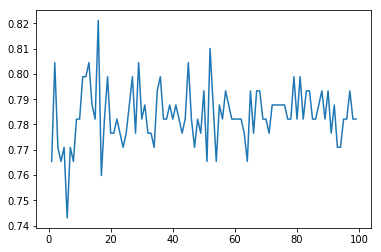

In [154]:
#At this point we noticed that the accuracy values and number of trees that they occur at change drastically with each iteration. This meant that
#iterating over number of trees was not an effective method for optimizing accuracy. Since we know that accuracy in general increases as number of trees
#increases, we plot the accuracy based on number of trees and look for the first region where the data becomes stable. We do this so we use the minimum 
#number of decision trees where the variance drops off. This maximizes accuracy per computation time because we want the prediction to run fast because it
#is hosted on Heroku. Stability occurs around 40 trees regardless of number of re-runs.
plt.plot(my_dict.keys(), my_dict.values())

In [155]:
#Score the model with 50 trees but use KFold to account for variation
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.776536312849162

In [156]:
#Unit testing was performed by executing kfold validation. This splits the data up into segments and uses 1 fold as test data
#and k-1 folds as training data. This returns k results with each fold being used as testing data exactly once.
#I then averaged the results to get a more accurate algorithm accuracy.
clf = RandomForestClassifier(n_estimators=50)
kfold_test_scores = []
# 10 folds of the data with the same random state
kf = KFold(n_splits=10, random_state=42)
#Get indices for each split (the data has 714 rows: the first split contains the slice indices from 0 to 72 as test data, and 73-713 as train data)
for train_index, test_index in kf.split(test):
    X_train, X_test = test.iloc[train_index], test.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    #Fit the model with this split, score it, and append the score to the list
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    kfold_test_scores.append(test_score)
#Print all scores, then average them
print(kfold_test_scores)
avg = (sum(kfold_test_scores)/len(kfold_test_scores))
print(avg)

[0.7083333333333334, 0.8194444444444444, 0.75, 0.7916666666666666, 0.8028169014084507, 0.7746478873239436, 0.7746478873239436, 0.7887323943661971, 0.8169014084507042, 0.8873239436619719]
0.7914514866979656


# Attempt 2: Scaling

In [170]:
#Attempt 2

#Create a scaler that scales the data down to a standard normal (Guassian) distribution (mean=0, standard deviation=1)
X_scaler = StandardScaler().fit(test)
X_scaled = X_scaler.transform(test)

In [171]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_scaled, target, random_state=42)

Maximum Value:  0.8156424581005587
Minimum Value:  0.7541899441340782
[20]


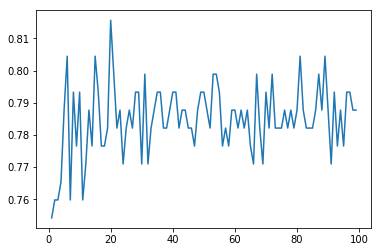

In [172]:
#Test random forest classifier with different numbers of decision trees
#Save the number of trees and accuracy in a dictionary
d_2 = {}

for i in np.arange(1,100):

    clf = RandomForestClassifier(n_estimators=i)
    clf_2 = clf.fit(X_train_2, y_train_2)
    d_2.update({i:clf_2.score(X_test_2,y_test_2)})
my_dict_2 = d_2

key_max_2 = max(my_dict_2.keys(), key=(lambda k: my_dict_2[k]))
key_min_2 = min(my_dict_2.keys(), key=(lambda k: my_dict_2[k]))

print('Maximum Value: ',my_dict_2[key_max_2])
print('Minimum Value: ',my_dict_2[key_min_2])

max_tree = [key for key,values in d_2.items() if values == d_2[key_max_2]]
print (max_tree)

plt.plot(my_dict_2.keys()  , my_dict_2.values())

In [173]:
#Stable around 50 trees.
#Score the model with 50 trees but use KFold to account for variation
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train_2, y_train_2)
clf.score(X_test_2, y_test_2)

0.7932960893854749

In [174]:
clf = RandomForestClassifier(n_estimators=50)
kfold_test_scores = []
# 10 folds of the data with the same random state
kf = KFold(n_splits=10, random_state=42)
#Get indices for each split (the data has 714 rows: the first split contains the slice indices from 0 to 72 as test data, and 73-713 as train data)
for train_index, test_index in kf.split(X_scaled):
    X_train_2, X_test_2 = X_scaled[train_index], X_scaled[test_index]
    y_train_2, y_test_2 = target[train_index], target[test_index]
    #Fit the model with this split, score it, and append the score to the list
    clf.fit(X_train_2, y_train_2)
    test_score = clf.score(X_test_2, y_test_2)
    kfold_test_scores.append(test_score)
#Print all scores, then average them
print(kfold_test_scores)
avg = (sum(kfold_test_scores)/len(kfold_test_scores))
print(avg)

[0.6805555555555556, 0.8333333333333334, 0.7361111111111112, 0.8194444444444444, 0.8591549295774648, 0.8028169014084507, 0.7464788732394366, 0.8028169014084507, 0.8169014084507042, 0.8873239436619719]
0.7984937402190925


In [175]:
#After running all methods, the scaler and regular methods are about equally accurate. I choose to save the scaler method (Accuracy=0.80)
#Save the scaler and the svc model to pkl files
joblib.dump(X_scaler, 'Resources/models/rf_scaler.pkl');
joblib.dump(clf, 'Resources/models/rf.pkl');

# Attempt - 3 (Binning)

In [139]:
#Prepare Dataset to be used in binning
binned_data = pd.read_csv('Resources/AG_train-test_v2.csv')
#test_2 corresponds to our X data for binning method
test_2 = binned_data.drop('Survived', axis = 1)
test_2.drop('Unnamed: 0', axis = 1, inplace=True)
binned_data.drop('Unnamed: 0', axis = 1, inplace=True)
#target is the same as before
target = binned_data['Survived']
binned_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,0,0
1,1,1,1,38.0,1,0,0,1
2,1,3,1,26.0,0,0,0,0
3,1,1,1,35.0,1,0,0,0
4,0,3,0,35.0,0,0,0,0


In [141]:
test_2.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,0,0
1,1,1,38.0,1,0,0,1
2,3,1,26.0,0,0,0,0
3,1,1,35.0,1,0,0,0
4,3,0,35.0,0,0,0,0


In [142]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(test_2, target, random_state=42)

Maximum Value:  0.7966101694915254
Minimum Value:  0.7005649717514124
[16]


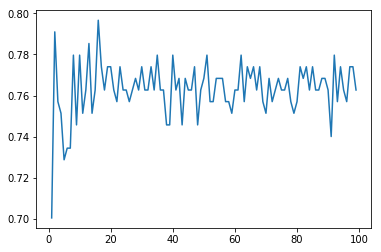

In [143]:
d_3 = {}

for i in np.arange(1,100):

    clf = RandomForestClassifier(n_estimators=i)
    clf_3 = clf.fit(X_train_3, y_train_3)
    d_3.update({i:clf_3.score(X_test_3,y_test_3)})
my_dict_3 = d_3

key_max_3 = max(my_dict_3.keys(), key=(lambda k: my_dict_3[k]))
key_min_3 = min(my_dict_3.keys(), key=(lambda k: my_dict_3[k]))

print('Maximum Value: ',my_dict_3[key_max_3])
print('Minimum Value: ',my_dict_3[key_min_3])

max_tree_3 = [key for key,values in d_3.items() if values == d_3[key_max_3]]
print (max_tree_3)

plt.plot(my_dict_3.keys()  , my_dict_3.values())

In [162]:
#The region becomes stable around 30 trees. Since we want to use the same number of trees for each test we use 50.
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train_3, y_train_3)
clf.score(X_test_3, y_test_3)

0.751412429378531

In [163]:
#Confirm using KFold
clf = RandomForestClassifier(n_estimators=50)
kfold_test_scores = []
# 10 folds of the data with the same random state
kf = KFold(n_splits=10, random_state=42)
#Get indices for each split (the data has 714 rows: the first split contains the slice indices from 0 to 72 as test data, and 73-713 as train data)
for train_index, test_index in kf.split(test_2):
    X_train_3, X_test_3 = test_2.iloc[train_index], test_2.iloc[test_index]
    y_train_3, y_test_3 = target[train_index], target[test_index]
    #Fit the model with this split, score it, and append the score to the list
    clf.fit(X_train_3, y_train_3)
    test_score = clf.score(X_test_3, y_test_3)
    kfold_test_scores.append(test_score)
#Print all scores, then average them
print(kfold_test_scores)
avg = (sum(kfold_test_scores)/len(kfold_test_scores))
print(avg)

[0.5070422535211268, 0.6197183098591549, 0.5070422535211268, 0.4788732394366197, 0.5211267605633803, 0.5492957746478874, 0.5492957746478874, 0.5142857142857142, 0.5571428571428572, 0.5714285714285714]
0.5375251509054325
